# 0. Setup

In [1]:
# libraries
import matplotlib.pyplot as plt
import pandas as pd
import os
import numpy as np
from PIL import Image as PilImage
from typing import Tuple
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.regularizers import L2
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# working directories
WORKDIR = os.path.abspath('D:\\Users\\nbakotic\\iccecme-dataset') # get the path of this file - image metadata
IMAGESDIR = os.path.join(WORKDIR, 'imagespng') # get the path of image folder
MAXPEAK_ALL = 'D:\\Users\\nbakotic\\iccecme-dataset\\images_maxpeak'

# gpu setup
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [2]:
#MAX PEAK SCALING FUNCTION

def denoise_image(image):
    # Sets pixel intensities that appear in less than 25th percentile to 0
    bin_count =  np.int(np.round(image.max()))
    if (bin_count < 1):
        bin_count = 1
    hist, bins = np.histogram(image.ravel(),bin_count)
    threshold = np.percentile(hist, 25)
    
    for i in range(len(hist)):
        if hist[i] < threshold:
            hist[i] = 0

    return hist

def max_peak_scaling(img):
    max_pixel_intensity = 255
    search_size = 32
    denoised = denoise_image(img)

    lower_bound = 0
    counter = 0
    for i in range(len(denoised)):
        if (denoised[i] != 0):
            counter += 1
        else:
            counter = 0
        if (counter == 1):
            lower_bound = i
        if (counter >= 10):
            break

    upper_bound = 0
    counter = 0
    for i in range(len(denoised) - 1, 0, -1):
        if (denoised[i] != 0):
            counter += 1
        else:
            counter = 0
        if (counter == 1):
            upper_bound = i
        if (counter >= 10):
            break

    if (lower_bound > upper_bound):
        temp = lower_bound
        lower_bound = upper_bound
        upper_bound = temp

    if (upper_bound != lower_bound):
        if (lower_bound + search_size < upper_bound):
            offset = np.where(denoised[lower_bound:lower_bound+search_size] == denoised[lower_bound:lower_bound+search_size].max())[0][0]
            lower_bound += offset
            offset = np.where(denoised[upper_bound-search_size:upper_bound] == denoised[upper_bound-search_size:upper_bound].max())[0][0]
            upper_bound = upper_bound - search_size + offset
    else:
        lower_bound = 0
        upper_bound = len(denoised)

    center = (upper_bound - lower_bound) / 2 + lower_bound
    width = upper_bound - lower_bound
    if (width == 0):
        width = 1
    retval = np.piecewise(
        img,
        [
            # conditions to check
            img <= lower_bound,
            img > upper_bound
        ],
        [  # what to apply on each condition
            0,  # where first condition true
            max_pixel_intensity,  # where second condition true
            lambda img: (  # where none of the conditions are true
                (img - center + width / 2) / width * max_pixel_intensity
            )
        ]
    )
    return retval

### Plotting Functions

In [3]:
# plot relationship between real and predicted values
def plot_diff(y_true, y_pred, title=''):
    plt.scatter(y_true, y_pred)
    plt.title(title)
    plt.xlabel('True Values')
    plt.ylabel('Predictions')
    plt.axis('equal')
    plt.axis('square')
    plt.xlim(plt.xlim())
    plt.ylim(plt.ylim())
    plt.show()


# plot a metric from the given model training history
def plot_metrics(history, metric_name, title):
    plt.title(title)
    plt.plot(history.history[metric_name], color='blue', label=metric_name)
    plt.plot(history.history['val_' + metric_name], color='green', label='val_' + metric_name)
    plt.show()

# 1.1 - Load and Process Metadata

In [4]:
# read metadata, drop target columns, original image size information and study description (natural language)
# fill unknown values of body part examined with 'UNKNOWN'
df = pd.read_csv(os.path.join(WORKDIR, 'metadata.csv'), index_col='id')
df = df.drop(columns=['WindowCenter' ,'WindowWidth', 'Rows', 'Columns', 'StudyDescription'])
df = df.fillna(value='UNKNOWN')

# one hot encode the remaining columns, drop original columns and redundant columns
mod_dummies = pd.get_dummies(df.Modality)
bpe_dummies = pd.get_dummies(df.BodyPartExamined)
hbit_dummies = pd.get_dummies(df.HighBit)
df = pd.concat([df, hbit_dummies, mod_dummies, bpe_dummies], axis='columns')
df = df.drop(columns=['Modality' ,'BodyPartExamined', 'HighBit', 7, 'XA','UNKNOWN'])

# read metadata and drop all columns except target labels - WindowWidth and WindowCenter
labels_df = pd.read_csv(os.path.join(WORKDIR, 'metadata.csv'), index_col='id')
labels_df = labels_df.drop(columns=['Modality', 'Rows', 'Columns', 'BodyPartExamined', 'HighBit', 'StudyDescription'])

# format numbers - find cells that contain two instead of one number and return only the first number
def extract_number_from_list(val):
    if ',' in val:
        idx = val.find(',')
        return val[1:idx]
    else:
        return val
    
labels_df = labels_df.applymap(extract_number_from_list)

# convert string values to float32
labels_df['WindowCenter'] = labels_df['WindowCenter'].astype('float32')
labels_df['WindowWidth'] = labels_df['WindowWidth'].astype('float32')

print(np.array(labels_df['WindowCenter']).max())
print(np.array(labels_df['WindowWidth']).max())

# scale numeric values to range from 0 to 255
labels_df['WindowCenter'] = np.maximum(np.array(labels_df['WindowCenter']), 0) / np.array(labels_df['WindowCenter']).max()  * 255.0
labels_df['WindowWidth'] = np.maximum(np.array(labels_df['WindowWidth']), 0) / np.array(labels_df['WindowWidth']).max()  * 255.0

# some images are completely black and contain only zero values, they will be removed from dataframes
# load image and drop row from dataframe if the image contains only zeroes (black)
def remove_black_images(df):
    for id in df.index:
        img = np.array(PilImage.open(os.path.join(IMAGESDIR, str(id) + '.png')).convert('L'))
        #some images only contain 0 values, even in original npy file and will be ignored in the dataset
        if (not(np.min(img) == np.max(img) == 0)):
            df.drop(id)

    return df

df = remove_black_images(df)
labels_df = remove_black_images(labels_df)

32767.0
65535.0


# 1.2 Load and Process Images
Before using the images for training, they were downscaled to size 128 x 128 pixels and saved as 8-bit grayscale png format. This section of the code was only used once to create the preprocessed dataset.

In [6]:
# image preprocessing functions
def save_image_slice(
    pixel_array: np.ndarray,
    fullpath: str,
    bits: int = 8,
    size: Tuple[int, int] = (None, None),
    verbose: bool = False,
):
    """Save a 2D image to disk.

    Args:
        pixel_array (np.ndarray): Pixel Array containing the image.

        fullpath (str): Full path to the new image (the full location
            where image should be saved). This should include the image
            name and extension.
        bits (int, optional): How many bits should the output image have.
            Defaults to 8.
        size (Tuple[int, int], optional): height and width of the
            new image, respectively.
            Defaults to (None, None).
        verbose (bool, optional): If True, prints out useful logs.
            Defaults to False.

    Raises:
        AssertionError: if the image provided is multidimensional.
    """
    image = pixel_array

    #if (bits > 8):
    #    image = image.astype(np.uint16)
    #else:
    #    image = image.astype(np.uint8)
    image = image.astype(np.uint8)

    image_to_save = resize_image(image, size, verbose=verbose, resample=PilImage.BILINEAR, zero_padding=True)

    head, tail = os.path.split(fullpath)
    os.makedirs(head, exist_ok=True)
    image_to_save.save(fullpath)
    return

def save_image_as_png(
    dcm_id: int,
    pixel_array: np.ndarray,
    folder_where_to_save: str = './',
    verbose: bool = False,
    size: Tuple[int, int] = (None, None),
    exist_ok=False,
    bits: int = 8,
):
    """Save an entire image as a single or multiple PNGs.

    If image is  multidimensional, it will be saved as multiple PNGs.

    Args:
        dcm_id (int): ID of the DICOM image. Used for nomenclature and
            saving images named as their IDs.
        pixel_array (np.ndarray): The image itself.
        folder_where_to_save (str, optional): Where to save the images.
            Defaults to './'.
        verbose (bool, optional): Whether to print out useful logs.
            Defaults to False.
        size (Tuple[int, int], optional): Height and width of the image
            respectively; the original image will be resized to
            these dimensions.
            If not provided, the image will not be resized.
            Defaults to (None, None).
        exist_ok (bool, optional): If False and the exported image exists,
            a new image will not be created. If True, the existing image
            will be overriden. If the image does not exist, this is ignored.
            Defaults to False.
        bits (int, optional): How many bits should the output image have.
            Defaults to 8.
    """
    #subfolder = str(dcm_id)[0:-3]

    fullpath = os.path.join(folder_where_to_save, f'{dcm_id}.png')
    if (exist_ok is False and os.path.isfile(fullpath)):
        log(f'Found {fullpath}, skipping DCM ID: {dcm_id}', verbose=verbose)
    else:
        os.makedirs(folder_where_to_save, exist_ok=True)
        save_image_slice(
            pixel_array,
            fullpath,
            bits=bits,
            verbose=verbose,
            size=size,
            )
        
def resize_image(
    image: np.ndarray,
    size: Tuple[int, int],
    verbose: bool = False,
    resample=PilImage.NEAREST,
    zero_padding: bool = False
):
    """Resize an image.

    This will resize the image to the specified size,
    and will add zero padding where necessary. The aspect ratio is always preserved.

    Args:
        image (np.ndarray): The image to resize, in a numpy array.

        size (Tuple[int, int]): The size of the output image.
            The first parameter is the output height, the second is the output width.
            One of these parameter can be None (either height or width), if both
            height and width are None, then an `AssertionError` is thrown.
            The size will be parsed according to the following options:
            - if height is None, then image will be scaled to fit the specified width.
            The height will be calculated automatically to preserve aspect ratio.
            - if width is None, the same thing applies as when height is missing.
            - if both height and width are set, then these will be considered
            the 'maximal' output size. If `zero_padding` is True, then the output image
            will have the same size as specified here, with padding added where it's needed.
            If `zero_padding` is False, then the output image size may vary,
            and it will scale so that the entire image *is not bigger than* this size.
            Aspect ratio is always preserved.

        verbose (bool, optional): Print useful logs. Defaults to False.

        resample (_type_, optional): Pillow image resampling option.
            Defaults to PilImage.NEAREST.

        zero_padding (bool, optional): Whether to add zero-padding.
            Used only if both height and width are set.
            Defaults to False.

    Returns:
        Pillow Image: The resized image, as an instance of Pillow.Image.
    """
    resized_image = PilImage.fromarray(image)
    curh, curw = image.shape
    aspect = curh / curw

    # make sure at least one of the sizes is provided
    assert size[0] is not None or size[1] is not None, 'At least one dimension size must be specified!'

    # convert to list so we can index the values
    # and change them if necessary
    # because tuple objects are immutable
    size = list(size)

    newh, neww = size
    if (size[0] is None):
        # if height not provided
        # calculate height from width in a way that preserves aspect ratio
        size[0] = round(size[1] * aspect)
        newh = size[0]
    elif (size[1] is None):
        # apply the same process for width
        size[1] = round(size[0] / aspect)
        neww = size[1]
    else:
        # both sizes are not None
        # this means that //maybe// we will have to add
        # zero padding later on
        # and it means that size[0] and size[1] are not
        # set in a way that preserves aspect ratio
        # so we'll just set new width and new height
        # in a way that preserves aspect an then later
        # add padding if necessary
        neww = min(size[1], curw / (curh / size[0]))
        neww = round(neww)
        newh = round(neww * aspect)
        # newh =
        # neww = round(curw / (curh / size[0]))
        # if (curh > curw):
        #     # neww = round(size[1] / aspect)
        #     # neww = round( (size[1] / aspect)))
        # else:

    # resize the core image
    resized_image = resized_image.resize((neww, newh), resample=resample)

    if (zero_padding is True):
        # once resized, now we have to (optionally) add zero-padding
        # first, calc the amount of padding which should be added
        # (padding is added by setting the top-left point where the image is
        # pasted onto an image of zeros)
        # note that, e.g., if size[1] is equal to new width, no padding will be added!
        pad_left = int((size[1] - neww) // 2)
        pad_top = int((size[0] - newh) // 2)

        # now let's make a new image which consists of zeros only
        # (which means color is 0)
        result = PilImage.new(resized_image.mode, (size[1], size[0]), color=0)
        # now we have an all-zero image. We should paste the resized image
        # in the middle of it
        result.paste(resized_image, (pad_left, pad_top))

        resized_image = result

    return resized_image

In [7]:
# Only run this once to create a folder of pngs


def read_file(file_name):
    imagepath = os.path.join('D:\\Users\\nbakotic\\iccecme-dataset\\images', f'{file_name}.npy')
    with open(imagepath, 'rb') as file:
        img = np.load(file)
    return img

for i in range(len(labels_df)):
    img = read_file(labels_df.index[i])
    maxpeak_scaled = max_peak_scaling(img)
    save_image_as_png(labels_df.index[i], maxpeak_scaled, MAXPEAK_ALL, False, (128, 128), True)


# 2. Create and Format Datasets

In [8]:
# load png images using dataframe index as file names and return a numpy array of images
def get_image(df):
    x_img = []

    for id in df.index:
        
        img = np.array(PilImage.open(os.path.join(MAXPEAK_ALL, str(id) + '.png')).convert('L'))
        # 1 grayscale dimension is dropped by default so it's added back manually
        img = np.expand_dims(img, -1) 

        x_img.append(img)

    x_img = np.array(x_img)

    return x_img

# format datasets - return tuple of labels as arrays
def format_output(data):
    window_center = data.pop('WindowCenter')
    window_center = np.array(window_center)
    window_width = data.pop('WindowWidth')
    window_width = np.array(window_width)
    return window_center, window_width

# choose train, validation and test rations
train_ratio = 0.72
validation_ratio = 0.08
test_ratio = 0.20

# select a random state seed for more repeatable results
split_seed = 9 # determined as best experimentally from 1 to 50, better split option might exist

# train - test split
x_train, x_test, y_train, y_test = train_test_split(df, labels_df, test_size=1-train_ratio, random_state=split_seed)

# test - validation split,validation is treated as train data
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=test_ratio/(test_ratio + validation_ratio), random_state=split_seed)

ids = y_test.index

# format outputs for each split
y_train = format_output(y_train)
y_val = format_output(y_val)
y_test = format_output(y_test)

# extract image from dataframe
x_train_img = get_image(x_train)
x_val_img = get_image(x_val)
x_test_img = get_image(x_test)

# convert dataframe to array
x_train_metadata = np.array(x_train)
x_val_metadata = np.array(x_val)
x_test_metadata = np.array(x_test)



# x_train means
train_means = np.mean(x_train_img)
train_stddev = np.std(x_train_img)
def image_scaler(images):
    return (images - train_means) / train_stddev

In [9]:
print(train_means, train_stddev)

66.15774964651258 75.70910528888723


# 3.1 MULTI OUTPUT MODEL

In [63]:
# build model

# hyperparameters to adjust
image_size = 128
regularization_factor = 0.01
learningrate = 0.0001

layer_1 = 32  
layer_2 = 64  
layer_3 = 128 
layer_4 = 256 
layer_5 = 256 

dense1 = '64' 
dense2 = '128'      


# neural network structure function
def build_mo_model():
    inputs = Input(shape=(image_size, image_size, 1))
    
    x = Conv2D(layer_1, 3, kernel_regularizer=L2(regularization_factor), kernel_initializer='HeNormal', activation='relu') (inputs)
    x = MaxPooling2D() (x)  

    x = Conv2D(layer_2, 3, kernel_regularizer=L2(regularization_factor), kernel_initializer='HeNormal', activation='relu') (x)
    x = MaxPooling2D() (x)    
    
    x = Conv2D(layer_3, 3, kernel_regularizer=L2(regularization_factor), kernel_initializer='HeNormal', activation='relu') (x)
    x = MaxPooling2D() (x)
    
    x = Conv2D(layer_4, 3, kernel_regularizer=L2(regularization_factor), kernel_initializer='HeNormal', activation='relu') (x)
    x = MaxPooling2D() (x)
    
    x = Conv2D(layer_5, 3, kernel_regularizer=L2(regularization_factor), kernel_initializer='HeNormal', activation='relu') (x)
    x = MaxPooling2D() (x) 
    
    
    x = Flatten() (x) 

    x = Dense(units=dense1, activation='relu', kernel_regularizer=L2(regularization_factor), kernel_initializer='HeNormal') (x)
    x = Dense(units=dense2, activation='relu', kernel_regularizer=L2(regularization_factor), kernel_initializer='HeNormal') (x)
               
               
    output1 = Dense(units='1', activation='linear', name="window_center")(x)
    output2 = Dense(units='1', activation='linear', name="window_width")(x)
    
    model = Model(inputs=inputs, outputs=[output1, output2])
    
    return model

mo_model = build_mo_model()

# optimizer, losses and metrics and compile model
optim = keras.optimizers.Adam(learning_rate=learningrate) 

loss1 = keras.losses.MeanSquaredError()
loss2 = keras.losses.MeanSquaredError()
losses = {
    "window_center": loss1,
    "window_width": loss2,
}

metric1 = tf.keras.metrics.MeanSquaredError()
metric2 = tf.keras.metrics.MeanSquaredError()
metrics = {
    "window_center": metric1,
    "window_width": metric2,
}
 
mo_model.compile(optimizer=optim, loss=losses, metrics=metrics)

In [ ]:
from sklearn.model_selection import KFold

# load png images using dataframe index as file names and return a numpy array of images
def get_image(df):
    x_img = []

    for id in df.index:
        
        img = np.array(PilImage.open(os.path.join(IMAGESDIR, str(id) + '.png')).convert('L'))
        # 1 grayscale dimension is dropped by default so it's added back manually
        img = np.expand_dims(img, -1) 

        x_img.append(img)

    x_img = np.array(x_img)

    return x_img

# format datasets - return tuple of labels as arrays
def format_output(data):
    window_center = data.pop('WindowCenter')
    window_center = np.array(window_center)
    window_width = data.pop('WindowWidth')
    window_width = np.array(window_width)
    return window_center, window_width


kf = KFold(10)

oos_y = []
oos_pred = []
fold = 0

x, x_holdout, y, y_holdout = train_test_split(df, labels_df, test_size=1-train_ratio, random_state=split_seed)

for train, test in kf.split(y):
    fold += 1
    print("Fold #{}".format(fold))

    x_train = get_image(labels_df.iloc[train])
    y_train = format_output(labels_df.iloc[train])
    x_test = get_image(labels_df.iloc[test])
    y_test = format_output(labels_df.iloc[test])

    model = build_mo_model()
    model.compile(optimizer=optim, loss=losses, metrics=metrics)

    monitor = tf.keras.callbacks.EarlyStopping(monitor='loss', mode='min', patience=10)
    model.fit(image_scaler(x_train), y_train, batch_size=256, epochs=200, verbose=0, callbacks=[monitor])

    pred = model.predict(image_scaler(x_test))

    oos_y.append(y_test)
    oos_pred.append(pred)

    score1 = mean_squared_error(pred[0], y_test[0])
    score2 = mean_squared_error(pred[1], y_test[1])
    print("Fold window center score (MSE): {}\nFold window width score (MSE): {}".format(score1, score2))

    score_c = 0
score_w = 0

for i in range(len(oos_y)):
    score_ci = mean_squared_error(oos_y[i][0], oos_pred[i][0])
    score_wi = mean_squared_error(oos_y[i][1], oos_pred[i][1])

    score_c += score_ci
    score_w += score_wi 

score_c /= 10
score_w /= 10

print(score_c, score_w)


In [64]:
import random
random.seed(199)

# train model, early stopping used to find optimal number of epochs
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=10)
mo_history = mo_model.fit(image_scaler(x_train_img), y_train, batch_size=256, epochs=100, validation_data=(image_scaler(x_val_img), y_val), verbose=0, callbacks=[stop_early])

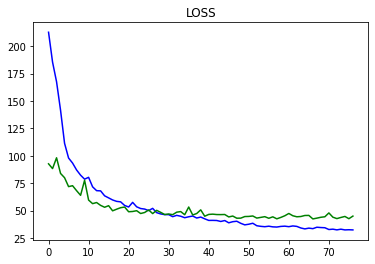

In [65]:
# plot loss 
plot_metrics(mo_history, metric_name='loss', title='LOSS')

In [5]:
#mo_model = tf.keras.models.load_model('./mo_model/') #load previously saved models, './mo_model_best/' had the best performance so far

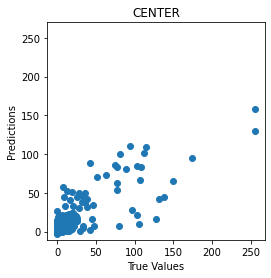

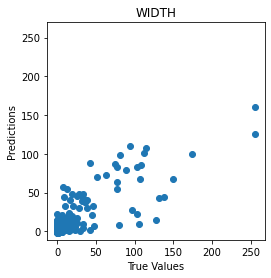

The accuracy of WindowCenter is 72.0%
The accuracy of WindowWidth is 68.0%
Mean absolute error of WindowCenter is 2.109999895095825
Mean absolute error of WindowWidth is 2.319999933242798
Mean squared error of WindowCenter is 30.8700008392334, RMSE: 5.559999942779541
Mean squared error of WindowWidth is 32.310001373291016, RMSE: 5.679999828338623


In [66]:
# make a prediction with the model
Y_pred = mo_model.predict(image_scaler(x_test_img))
center_pred = Y_pred[0]
width_pred = Y_pred[1]

test_center = y_test[0]
test_width = y_test[1]

# difference between true and predicted values
plot_diff(test_center, center_pred, title='CENTER')
plot_diff(test_width, width_pred, title='WIDTH')


# calculate and print metrics
mo_score_center = r2_score(test_center, center_pred.reshape(-1))
print("The accuracy of WindowCenter is {}%".format(round(mo_score_center, 2) *100))
mo_score_width = r2_score(test_width, width_pred.reshape(-1))
print("The accuracy of WindowWidth is {}%".format(round(mo_score_width, 2) *100))

mo_mae_center =  mean_absolute_error(test_center, center_pred.reshape(-1))
print("Mean absolute error of WindowCenter is {}".format(round(mo_mae_center, 2)))
mo_mae_width =  mean_absolute_error(test_width, width_pred.reshape(-1))
print("Mean absolute error of WindowWidth is {}".format(round(mo_mae_width, 2)))

mo_mse_center = mean_squared_error(test_center, center_pred.reshape(-1))
print("Mean squared error of WindowCenter is {}, RMSE: {}".format(round(mo_mse_center, 2), round(np.sqrt(mo_mse_center), 2)))
mo_mse_width = mean_squared_error(test_width, width_pred.reshape(-1))
print("Mean squared error of WindowWidth is {}, RMSE: {}".format(round(mo_mse_width, 2), round(np.sqrt(mo_mse_width), 2)))

In [67]:
predicted_image_df = pd.DataFrame({"Index": ids,
                                   "Predicted window center (image only)": center_pred.reshape(-1),
                                   "Actual window center": test_center,
                                   "Difference center":np.abs(test_center - center_pred.reshape(-1)),
                                   "Predicted window width (image only)": width_pred.reshape(-1),
                                   "Actual window width": test_width,
                                   "Difference width":np.abs(test_width - width_pred.reshape(-1))
                                   })

In [68]:
predicted_image_df.sort_values("Difference center", axis=0, ascending=False)

,Index,Predicted window center (image only),Actual window center,Difference center,Predicted window width (image only),Actual window width,Difference width
847,12305911,129.489212,255.000000,125.510788,125.331398,255.000000,129.668610
2063,15048076,16.638069,128.165375,111.527306,15.146224,128.163422,113.017197
3040,11398280,158.342255,255.000000,96.657745,159.957352,255.000000,95.042648
4383,25902931,9.681712,105.589157,95.907448,9.979650,105.587547,95.607895
1752,11426122,44.627766,137.441788,92.814026,44.060787,137.439682,93.378891
...,...,...,...,...,...,...,...
2376,24252431,0.426596,0.428022,0.001426,4.977139,1.011673,3.965466
3146,27031180,2.987436,2.988372,0.000936,1.654494,1.463035,0.191459
631,11789350,2.956425,2.957244,0.000819,1.644673,1.704280,0.059607
2294,10846075,0.778969,0.778222,0.000747,0.750627,0.778210,0.027583


In [22]:
#Save model
#mo_model.save('./mo_model/', save_format='tf') #save a model

INFO:tensorflow:Assets written to: ./mo_model/assets


# 3.2 MULTI INPUT MODEL - ADDITION OF METADATA

In [70]:
# build model

# hyperparameters to adjust
image_size = 128
regularization_factor = 0.01
learningrate = 0.0001

layer_1 = 32  
layer_2 = 64  
layer_3 = 128 
layer_4 = 256 
layer_5 = 256 

metadata_1 = '32'
metadata_2 = '64'
metadata_3 = '128'
metadata_4 = '256'

dense_1 = '64'


def build_mi_model():
    # image and metadata inputs
    input_img = Input(shape=(image_size, image_size, 1))
    input_metadata = Input(shape=(35,))
    

    # CNN
    x = Conv2D(layer_1, 3, kernel_regularizer=L2(regularization_factor), activation='relu') (input_img)
    x = MaxPooling2D() (x)  

    x = Conv2D(layer_2, 3, kernel_regularizer=L2(regularization_factor), activation='relu') (x)
    x = MaxPooling2D() (x)    
    
    x = Conv2D(layer_3, 3, kernel_regularizer=L2(regularization_factor), activation='relu') (x)
    x = MaxPooling2D() (x)
    
    x = Conv2D(layer_4, 3, kernel_regularizer=L2(regularization_factor), activation='relu') (x)
    x = MaxPooling2D() (x)
    
    x = Conv2D(layer_5, 3, kernel_regularizer=L2(regularization_factor), activation='relu') (x)
    x = MaxPooling2D() (x)

    x = Flatten() (x)

    # metadata dense layers
    metadata = Dense(units=metadata_1, activation='relu', kernel_regularizer=L2(regularization_factor)) (input_metadata) 
    metadata = Dense(units=metadata_2, activation='relu', kernel_regularizer=L2(regularization_factor)) (metadata)  
    metadata = Dense(units=metadata_3, activation='relu', kernel_regularizer=L2(regularization_factor)) (metadata) 
    metadata = Dense(units=metadata_4, activation='relu', kernel_regularizer=L2(regularization_factor)) (metadata) 


    # combined layers
    combined = keras.layers.concatenate([x, metadata])
               
    x = Dense(units=dense_1, activation='relu', kernel_regularizer=L2(regularization_factor)) (combined) 
               
    output1 = Dense(units='1', activation='linear', name="window_center")(x)
    output2 = Dense(units='1', activation='linear', name="window_width")(x)
    
    model = Model(inputs=[input_img, input_metadata], outputs=[output1, output2])
    
    return model

mi_model = build_mi_model()

# optimizer, losses and metrics and compile model
optim = keras.optimizers.Adam(learning_rate=learningrate)

loss1 = keras.losses.MeanSquaredError()
loss2 = keras.losses.MeanSquaredError()
losses = {
    "window_center": loss1,
    "window_width": loss2,
}

metric1 = tf.keras.metrics.MeanSquaredError()
metric2 = tf.keras.metrics.MeanSquaredError()
metrics = {
    "window_center": metric1,
    "window_width": metric2,
}

mi_model.compile(optimizer=optim, loss=losses, metrics=metrics)

In [71]:
# train model, early stopping used to find optimal number of epochs
stop_early_mi = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=10)
mi_history = mi_model.fit(x=[image_scaler(x_train_img), x_train_metadata], y = y_train, batch_size=256, epochs=100, validation_data=([image_scaler(x_val_img), x_val_metadata], y_val), verbose=0, callbacks=[stop_early_mi])

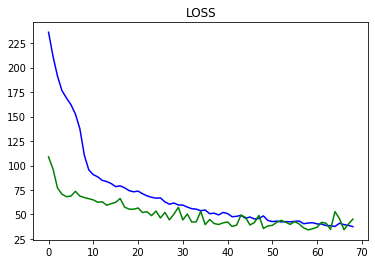

In [72]:
# plot loss
plot_metrics(mi_history, metric_name='loss', title='LOSS')

In [7]:
#mi_model = tf.keras.models.load_model('./mi_model/') #load previously saved models, './mi_model_best/' had the best performance so far

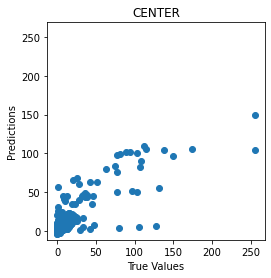

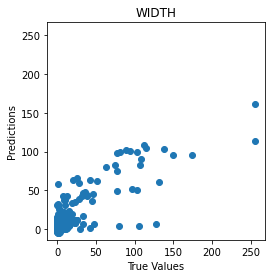

The accuracy of WindowCenter is 76.0%
The accuracy of WindowWidth is 71.0%
Mean absolute error of WindowCenter is 1.7200000286102295
Mean absolute error of WindowWidth is 2.25
Mean squared error of WindowCenter is 26.219999313354492, RMSE: 5.119999885559082
Mean squared error of WindowWidth is 28.93000030517578, RMSE: 5.380000114440918


In [73]:
# make a prediction with the model
Y_pred = mi_model.predict([image_scaler(x_test_img), x_test_metadata])
center_pred = Y_pred[0]
width_pred = Y_pred[1]

test_center = y_test[0]
test_width = y_test[1]

# difference between true and predicted values
plot_diff(test_center, center_pred, title='CENTER')
plot_diff(test_width, width_pred, title='WIDTH')

# calculate and print metrics
mi_score_center = r2_score(test_center, center_pred.reshape(-1))
print("The accuracy of WindowCenter is {}%".format(round(mi_score_center, 2) *100))
mi_score_width = r2_score(test_width, width_pred.reshape(-1))
print("The accuracy of WindowWidth is {}%".format(round(mi_score_width, 2) *100))

mi_mae_center =  mean_absolute_error(test_center, center_pred.reshape(-1))
print("Mean absolute error of WindowCenter is {}".format(round(mi_mae_center, 2)))
mi_mae_width =  mean_absolute_error(test_width, width_pred.reshape(-1))
print("Mean absolute error of WindowWidth is {}".format(round(mi_mae_width, 2)))

mi_mse_center = mean_squared_error(test_center, center_pred.reshape(-1))
print("Mean squared error of WindowCenter is {}, RMSE: {}".format(round(mi_mse_center, 2), round(np.sqrt(mi_mse_center), 2)))
mi_mse_width = mean_squared_error(test_width, width_pred.reshape(-1))
print("Mean squared error of WindowWidth is {}, RMSE: {}".format(round(mi_mse_width, 2), round(np.sqrt(mi_mse_width), 2)))

In [26]:
# save model
#mi_model.save('./mi_model/', save_format='tf')

INFO:tensorflow:Assets written to: ./mi_model/assets


# COMPARE RESULTS

In [22]:

predicted_metadata_df = pd.DataFrame({"Index": ids,
                                      "Predicted window center (with metadata)": center_pred.reshape(-1),
                                      "Actual window center": test_center,
                                      "Difference center":np.abs(test_center - center_pred.reshape(-1)),
                                      "Predicted window width (with metadata)": width_pred.reshape(-1),
                                      "Actual window width": test_width,
                                      "Difference width":np.abs(test_width - width_pred.reshape(-1))
                                    })

In [23]:
predicted_image_df.sort_values("Difference center", axis=0, ascending=False)

,Index,Predicted window center (image only),Actual window center,Difference center,Predicted window width (image only),Actual window width,Difference width
847,12305911,121.860817,255.000000,133.139191,129.002716,255.000000,125.997284
2063,15048076,6.323761,128.165375,121.841614,7.548367,128.163422,120.615051
4383,25902931,2.700348,105.589157,102.888809,4.939785,105.587547,100.647758
66,10845942,68.786888,149.597610,80.810722,72.256432,149.595322,77.338890
3040,11398280,179.576370,255.000000,75.423630,184.408691,255.000000,70.591309
...,...,...,...,...,...,...,...
3885,12327833,2.959535,2.957244,0.002291,1.826218,1.704280,0.121938
3461,11096426,3.285389,3.284097,0.001292,2.911275,2.194552,0.716723
596,29474832,1.534311,1.533097,0.001213,0.151221,1.669261,1.518040
4257,22246660,2.802368,2.801599,0.000769,0.536109,1.898833,1.362724
